In [440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as srn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [441]:
data = pd.read_csv("data.csv")
data = data.dropna()
data = data.drop_duplicates()
data = data.reset_index(drop=True)

In [442]:
data.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [443]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     19999 non-null  object
 1   Emotion  19999 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [444]:
data.describe(include="all")

,Text,Emotion
count,19999,19999
unique,19948,6
top,i will feel as though i am accepted by as well...,joy
freq,2,6760


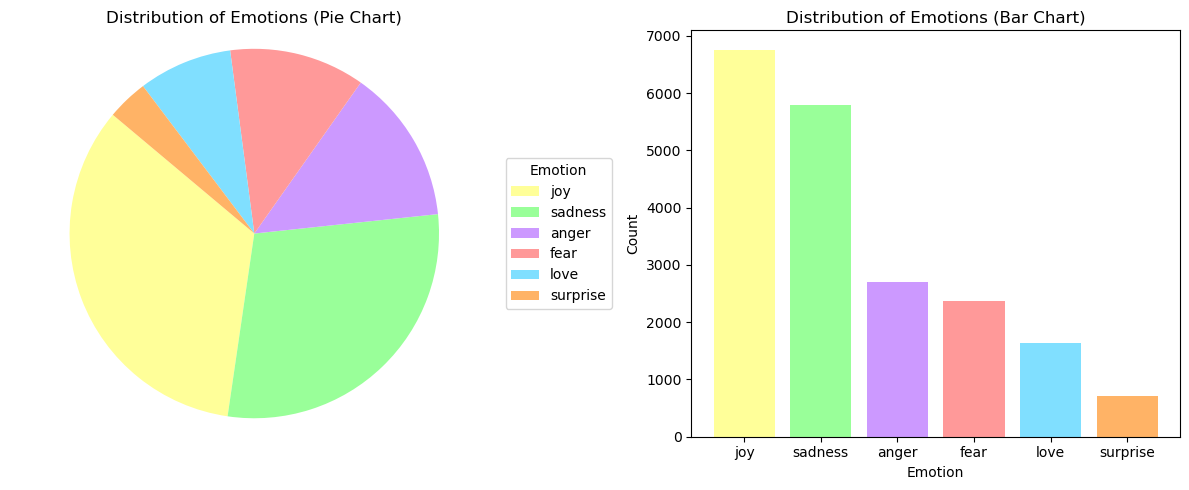

In [445]:
import matplotlib.pyplot as plt

counts = data['Emotion'].value_counts()
colors = ["#FFFF99", "#99FF99", "#CC99FF", "#FF9999", "#80DFFF", "#FFB366"]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pie(counts, startangle=140, colors=colors)
plt.legend(counts.index, title='Emotion', loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('equal')
plt.title('Distribution of Emotions (Pie Chart)')

plt.subplot(1, 2, 2)
emotion_counts = data['Emotion'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values, color=colors)
plt.title('Distribution of Emotions (Bar Chart)')
plt.xlabel('Emotion')
plt.ylabel('Count')

plt.tight_layout()

plt.show()


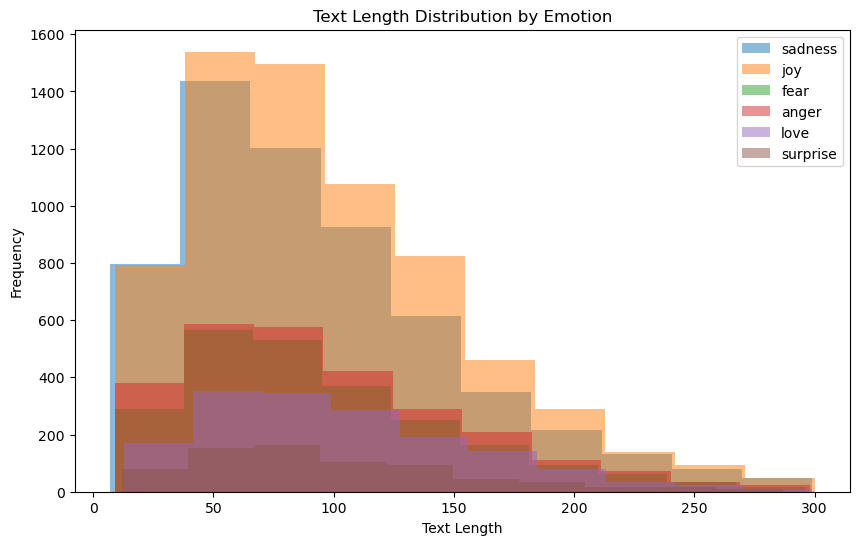

In [446]:
data['Text_Length'] = data['Text'].apply(len)

plt.figure(figsize=(10, 6))
for emotion in emotions:
    plt.hist(data[data['Emotion'] == emotion]['Text_Length'], alpha=0.5, label=emotion)

plt.title('Text Length Distribution by Emotion')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [484]:
def data_preprocessing(text):
    t=""
    for achar in text:
        if achar not in string.punctuation:
                t+=achar
    text=t            
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in string.punctuation]

    stopword_list = set(stopwords.words("english"))
    avoid_these = ['very', 'too', 'never']
    remove_these = ['and', 'feel','im', 'my', 'like', 'get']

    result = []
    for token in tokens:
        if token not in remove_these and token not in stopword_list:
            result.append(token)
        elif token in avoid_these:
            result.append(token)

    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(token, pos='v') for token in result]
    
    tokens.clear()
    
    for token in result:
        if token not in remove_these and token not in stopword_list:
            tokens.append(token)
        elif token in avoid_these:
            tokens.append(token)

    return ' '.join(tokens)

In [448]:
data['Text'] = data['Text'].apply(data_preprocessing)

In [449]:
data.head()

,Text,Emotion,Text_Length
0,rather rotten very ambitious right,sadness,59
1,update blog shitty,sadness,41
2,never make separate ever want ashamed,sadness,97
3,leave bouquet red yellow tulips arm slightly o...,joy,113
4,little vain one,sadness,47


In [450]:
memory_usage = data.memory_usage(deep=True).sum()

print(f"Memory usage of the DataFrame: {memory_usage / (1024**2):.2f} MB")

Memory usage of the DataFrame: 3.39 MB


In [451]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

label_encoder = LabelEncoder()
data['Emotion_encoded'] = label_encoder.fit_transform(data['Emotion'])

num_features_to_select = 1000 
chi2_selector = SelectKBest(chi2, k=num_features_to_select)
tfidf_matrix_selected = chi2_selector.fit_transform(tfidf_matrix, data['Emotion_encoded'])

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_selected, data['Emotion_encoded'], test_size=0.2, random_state=42)

classifier = SVC()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.87325


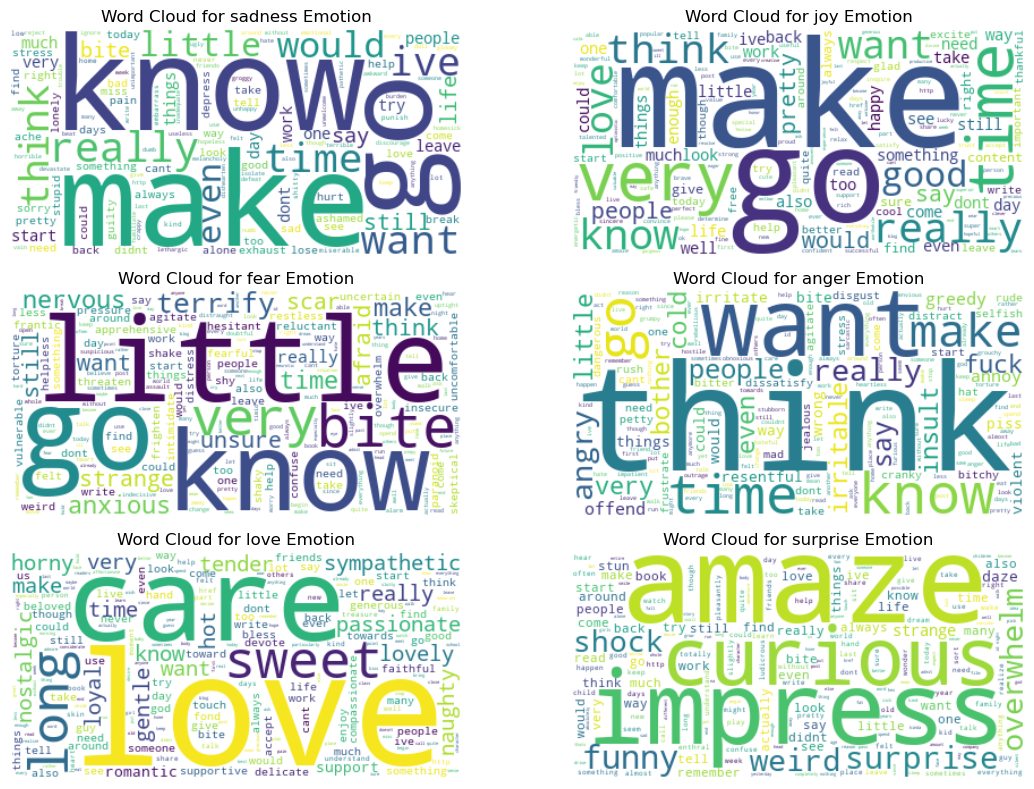

In [452]:
emotion_texts = {}
for emotion in data['Emotion'].unique():
    emotion_texts[emotion] = ' '.join(data[data['Emotion'] == emotion]['Text'])

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

axes = axes.flatten()

for i, (emotion, text) in enumerate(emotion_texts.items()):
    emotion_vectorized = tfidf_vectorizer.transform([text])
    
    feature_names = tfidf_vectorizer.get_feature_names_out()

    tfidf_values = emotion_vectorized.toarray()[0]

    word_tfidf_dict = dict(zip(feature_names, tfidf_values))

    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_tfidf_dict)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud for {emotion} Emotion')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


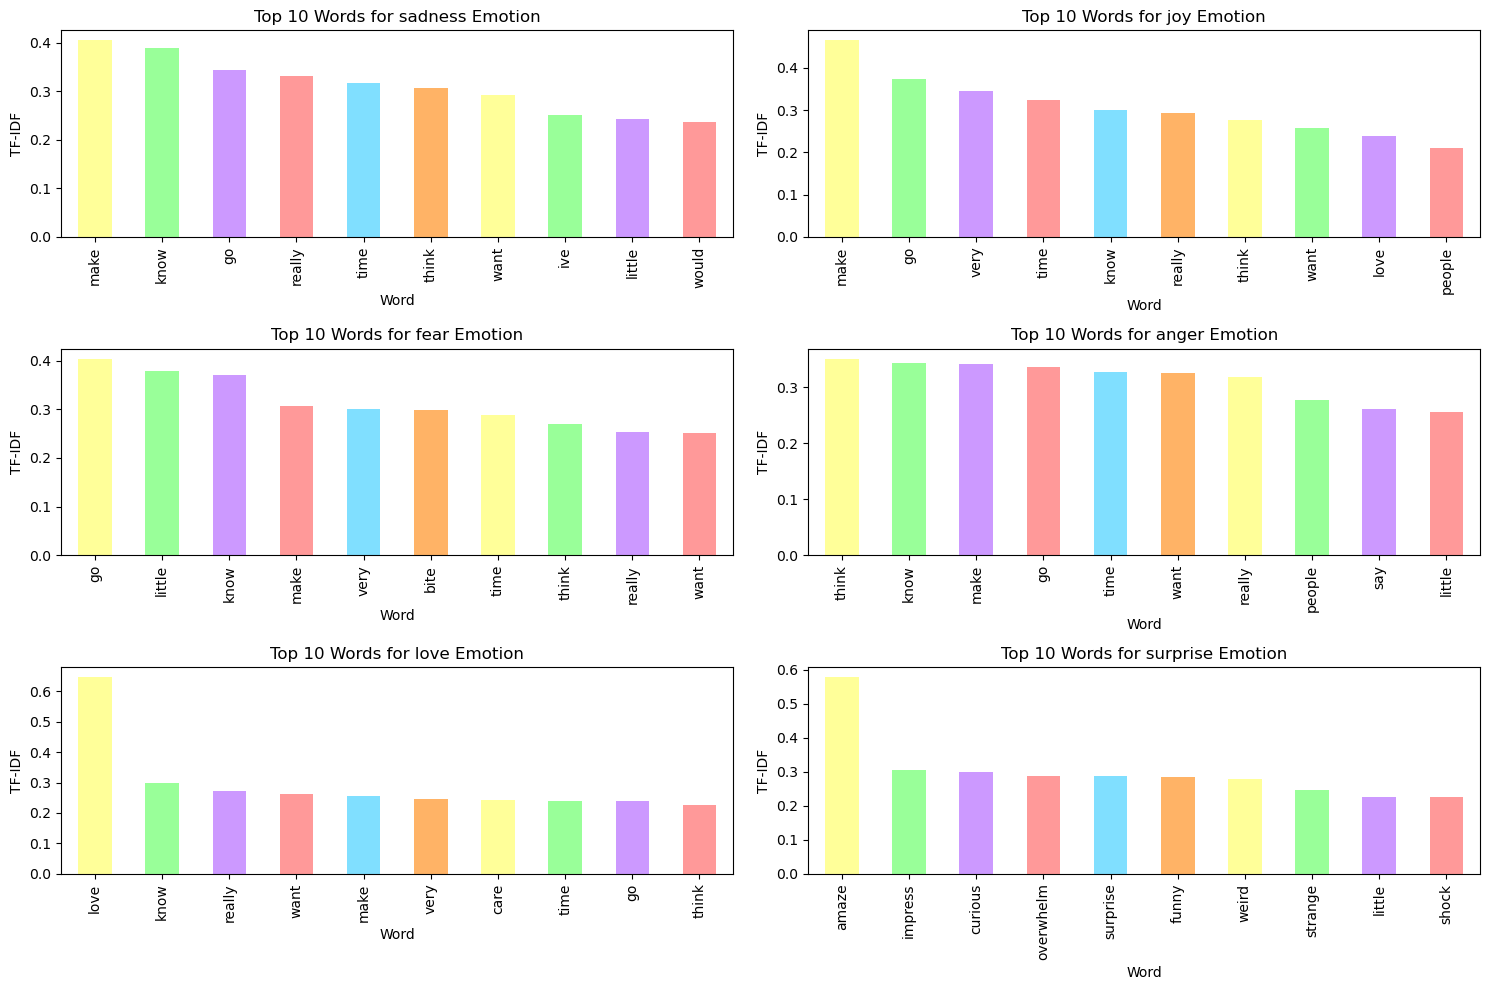

In [453]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

axes = axes.flatten()

for i, (emotion, text) in enumerate(emotion_texts.items()):
    # Using TfidfVectorizer to calculate TF-IDF values
    tfidf_vectorizer = TfidfVectorizer(max_features=10)
    emotion_vectorized = tfidf_vectorizer.fit_transform([text])
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_values = emotion_vectorized.toarray()[0]

    # Creating a DataFrame to easily sort and plot the top 10 words
    df = pd.DataFrame({'Word': feature_names, 'TF-IDF': tfidf_values})
    df = df.sort_values(by='TF-IDF', ascending=False).head(10)

    # Plotting bar chart
    df.plot(kind='bar', x='Word', y='TF-IDF', ax=axes[i], color=colors)
    
    axes[i].set_title(f'Top 10 Words for {emotion} Emotion')
    axes[i].set_xlabel('Word')
    axes[i].set_ylabel('TF-IDF')
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()


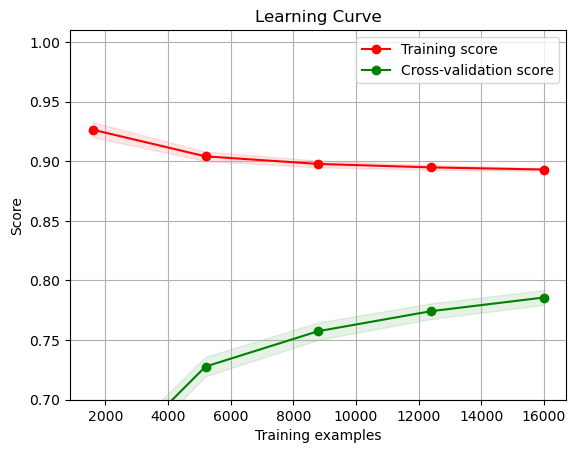

In [454]:
X = data['Text']
y = data['Emotion']

model = make_pipeline(CountVectorizer(), MultinomialNB())

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curve"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(model, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [486]:
response="I'm feeling a bit sad today, but I don't know it will last till when?"
response=data_preprocessing(response)

temp = tfidf_vectorizer.fit_transform(response)
temp
#classifier.predict()

ValueError: Iterable over raw text documents expected, string object received.